## Simulate Stark effect for linear molecule OCS


The problem of linear molecule rotation in the presence of static electric field can be solved easily using ready analytical expressions for the matrix elements of dipole moment.
For linear molecule, the laboratory-frame $(X,Y,Z)$ and molecular-frame $(x,y,z)$ projections of dipole moment are related as $\mu_Z=\cos(\theta)\mu_z$, where $\theta$ is the Euler angle. From the properties of spherical harmonics, obtain $\cos(\theta)=2\sqrt{\pi/3}Y_{1,0}$. Thus, the total Hamiltonian for linear molecule in static electric field, oriented along $Z$ axis, can be written as
\begin{align}
H=BJ^2-2\sqrt{\pi/3}Y_{1,0}\mu_z F_Z.
\end{align}

We solve the Schrödinger equation using variational method, i.e., by expanding the total wave function as linear combination of basis functions, which are eigenfunctions of Hamiltonian $H_0 = BJ^2$ describing field-free rotation of linear molecule. It is well known that eigenfunctions of $J^2$ operator are spherical harmonics $Y_{J,m}$.

The matrix representation of $H$ in the basis of spherical harmonics is
\begin{align}
\langle Y_{J',m'}|H| Y_{J,m}\rangle = BJ(J+1)\delta_{J,J'}\delta_{m,m'} - 2\sqrt{\pi/3}\mu_z F_Z\langle Y_{J',m'}|Y_{1,0}| Y_{J,m}\rangle.
\end{align}

Using the product rule for spherical harmonics, obtain
\begin{align}
\langle Y_{J',m'}|Y_{1,0}| Y_{J,m}\rangle = (-1)^{m'}\sqrt{\frac{(2J'+1)(2J+1)(2+1)}{4\pi}}
\left(\begin{array}{ccc}J'&1&J\\-m'&0&m\end{array}\right)
\left(\begin{array}{ccc}J'&1&J\\0&0&0\end{array}\right).
\end{align}

The code below implements it

In [8]:
import numpy as np
from sympy.physics.wigner import wigner_3j

B = 0.203   # in cm^-1
dz = 0.55   # in Debye
fz = 10000   # in V/cm
conv_to_cm = 1.679201682918921e-05 # converts dz[Debye]*Fz[V/cm] into cm^-1
# note on unit conversion: Debye = 1/c * 10^{-21} Coulomb*meter and Coulomb*Volt = Joule

energy = lambda J: B*J*(J+1)
costheta_me = lambda J1, m1, J2, m2: 2*np.sqrt(np.pi/3.0) * (-1)**m1 * np.sqrt((2*J1+1)*(2*J2+1)*3/(4*np.pi)) \
                                     * wigner_3j(J1, 1, J2, -m1, 0, m2) * wigner_3j(J1, 1, J2, 0, 0, 0)

Jmax = 10
Jm_quanta = [(J, m) for J in range(Jmax+1) for m in range(-J, J+1)]

H0 = np.diag([energy(J) for (J,m) in Jm_quanta])
H = np.array([[costheta_me(J1, m1, J2, m2) for (J1, m1) in Jm_quanta] for (J2, m2) in Jm_quanta], dtype=np.float64)

Htot = H0 - H * dz * fz * conv_to_cm
enr, vec = np.linalg.eigh(Htot)
print(enr)

[-6.91681529e-03  4.03902042e-01  4.03902042e-01  4.10113514e-01
  1.21699992e+00  1.21699992e+00  1.21849733e+00  1.21849733e+00
  1.21900241e+00  2.43541649e+00  2.43541649e+00  2.43599970e+00
  2.43599970e+00  2.43635009e+00  2.43635009e+00  2.43646697e+00
  4.05961804e+00  4.05961804e+00  4.05990445e+00  4.05990445e+00
  4.06010910e+00  4.06010910e+00  4.06023192e+00  4.06023192e+00
  4.06027286e+00  6.08973066e+00  6.08973066e+00  6.08989225e+00
  6.08989225e+00  6.09001794e+00  6.09001794e+00  6.09010773e+00
  6.09010773e+00  6.09016161e+00  6.09016161e+00  6.09017957e+00
  8.52579992e+00  8.52579992e+00  8.52589995e+00  8.52589995e+00
  8.52598181e+00  8.52598181e+00  8.52604547e+00  8.52604547e+00
  8.52609095e+00  8.52609095e+00  8.52611823e+00  8.52611823e+00
  8.52612733e+00  1.13678455e+01  1.13678455e+01  1.13679117e+01
  1.13679117e+01  1.13679677e+01  1.13679677e+01  1.13680136e+01
  1.13680136e+01  1.13680492e+01  1.13680492e+01  1.13680747e+01
  1.13680747e+01  1.13680

Let's repeat the above calculations for different values of field and plot the Stark curves - state energies versus field

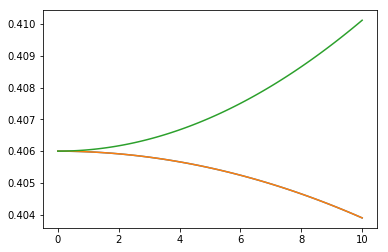

In [9]:
import matplotlib.pyplot as plt

stark = []
for fz in np.linspace(0, 10, 100): # field in kV
    #print("do fz =", fz, "kV/cm ...")
    Htot = H0 - H * dz * fz*1000 * conv_to_cm
    enr, vec = np.linalg.eigh(Htot)
    stark.append([fz, *enr])
stark = np.array(stark)

plt.plot(stark[:,0], stark[:,2])
plt.plot(stark[:,0], stark[:,3])
plt.plot(stark[:,0], stark[:,4])

We can now run same calculations using `watie` and `extfield`

In [10]:
# First, compute and store in file rotational energies and matrix elements of dipole moment operator

from richmol.watie import RigidMolecule, SymtopBasis, JJ, CartTensor
import numpy as np

#######################################################################
# OCS rotational energies and richmol matrix elements of dipole moment
# using ab initio values computed at CCSD(T)/ACVQZ level of theory
#######################################################################

ocs = RigidMolecule()

ocs.XYZ = ("angstrom",
    "C",  0.0,  0.0,  -0.522939783141,
    "O",  0.0,  0.0,  -1.680839357,
    "S",  0.0,  0.0,  1.037160128)

ocs.tensor = ("dipole moment", [0, 0, -0.31093])

#ocs.frame = "pas"

Bx, By, Bz = ocs.B
print("rotational constants:", Bx, By, Bz)

# compute rotational energies for J = 0..10

Jmax = 10

wavefunc = {}
for J in range(Jmax + 1):
    bas = SymtopBasis(J, linear=True)
    H = Bx * JJ(bas) # linear molecule Hamiltonian
    hmat = bas.overlap(H)
    enr, vec = np.linalg.eigh(hmat.real)
    wavefunc[J] = bas.rotate(krot=(vec.T, enr))

# store rotational energies
for J in range(Jmax + 1):
    wavefunc[J].store_richmol("ocs_j0_j"+str(Jmax)+".h5")

mu = CartTensor(ocs.tensor["dipole moment"], name='mu', units='au', descr="ab initio CCSD(T)/ACVQZ")

# compute and store matrix elements of dipole moment
for J1 in range(Jmax + 1):
    for J2 in range(J1, Jmax + 1):
        if abs(J1 - J2) > 1: continue # selection rules
        mu.store_richmol(wavefunc[J1], wavefunc[J2], "ocs_j0_j"+str(Jmax)+".h5", thresh=1e-10)

/home/andrey/.local/lib/python3.6/site-packages/richmol-0.1a1-py3.6.egg/richmol/watie.py:305: RuntimeWarning: divide by zero encountered in double_scalars
  return [convert_to_cm/val for val in np.diag(imom)]


rotational constants: 0.203439376816691 0.203439376816691 inf


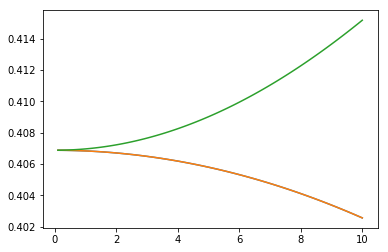

In [11]:
# Load field-free data and compute field-dressed states

from richmol.extfield import States, Tensor, Hamiltonian, mu_au_to_Cm, planck, c_vac
from richmol import rchm

Jmax = 10

richmol_file = "ocs_j0_j10.h5"

# field-free states
states = States(richmol_file, 'h0', [J for J in range(Jmax + 1)], emin=0, emax=10000)

# dipole matrix elements
mu = Tensor(richmol_file, 'mu', states, states)
mu.mul(-1.0)

stark = []

for Fz in np.linspace(0.1, 10, 100): # field in kV

    #print("do fz =", Fz, "kV/cm ...")
    field = [0, 0, Fz * 1000 *100] # field in V/m

    # multiply dipole with external field
    mu2 = mu * field

    # convert dipole[au]*field[V/m] into [cm^-1]
    fac = mu_au_to_Cm / (planck * c_vac) / 100.0
    mu2.mul(fac)

    # combine -dipole*field with field-free Hamiltonian
    ham = Hamiltonian(mu=mu2, h0=states)

    # matrix representation of Hamiltonian
    hmat = ham.tomat(form='full')

    # eigenvalues and eigenvectors
    enr, vec = np.linalg.eigh(hmat)

    stark.append([Fz, *enr])

stark = np.array(stark)

plt.plot(stark[:,0], stark[:,2])
plt.plot(stark[:,0], stark[:,3])
plt.plot(stark[:,0], stark[:,4])


Note, these results are expected to be slightly different from those above because of the differences in rotational $B$ constant and dipole moment.